In [1]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne import io
from mne.datasets import sample
from mne.minimum_norm import read_inverse_operator, source_induced_power

print(__doc__)

Automatically created module for IPython interactive environment


In [2]:
data_path = sample.data_path()
meg_path = data_path / "MEG" / "sample"
raw_fname = meg_path / "sample_audvis_raw.fif"
fname_inv = meg_path / "sample_audvis-meg-oct-6-meg-inv.fif"
label_name = "Aud-rh"
fname_label = meg_path / "labels" / f"{label_name}.label"

tmin, tmax, event_id = -0.2, 0.5, 2

# Setup for reading the raw data
raw = io.read_raw_fif(raw_fname)
events = mne.find_events(raw, stim_channel="STI 014")
inverse_operator = read_inverse_operator(fname_inv)

include = []
raw.info["bads"] += ["MEG 2443", "EEG 053"]  # bads + 2 more

# Picks MEG channels
picks = mne.pick_types(
    raw.info, meg=True, eeg=False, eog=True, stim=False, include=include, exclude="bads"
)
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

# Load epochs
epochs = mne.Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    picks=picks,
    baseline=(None, 0),
    reject=reject,
    preload=True,
)

# Compute a source estimate per frequency band including and excluding the
# evoked response
freqs = np.arange(7, 30, 2)  # define frequencies of interest
label = mne.read_label(fname_label)
n_cycles = freqs / 3.0  # different number of cycle per frequency

# subtract the evoked response in order to exclude evoked activity
epochs_induced = epochs.copy().subtract_evoked()

plt.close("all")




Opening raw data file C:\Users\Hsukin\mne_data\MNE-sample-data\MEG\sample\sample_audvis_raw.fif...
    Read a total of 3 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
    Range : 25800 ... 192599 =     42.956 ...   320.670 secs
Ready.
320 events found
Event IDs: [ 1  2  3  4  5 32]
Reading inverse operator decomposition from C:\Users\Hsukin\mne_data\MNE-sample-data\MEG\sample\sample_audvis-meg-oct-6-meg-inv.fif...
    Reading inverse operator info...
    [done]
    Reading inverse operator decomposition...
    [done]
    305 x 305 full covariance (kind = 1) found.
    Read a total of 4 projection items:
        PCA-v1 (1 x 102) active
        PCA-v2 (1 x 102) active
        PCA-v3 (1 x 102) active
        Average EEG reference (1 x 60) active
    Noise covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 2) found.
    Source covariance matrix read.
    22494 x 22494 diagonal covariance (kind = 6) found.
 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: percent)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s finished


[done]
Picked 305 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 81 -> 81
Computing source power ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: percent)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s finished


Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 305 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 81 -> 81
Computing source power ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: percent)
Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 1


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.3s finished


    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a noise covariance matrix with rank 302 (3 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 305 channels from the data
Computing inverse...
    Eigenleads need to be weighted ...
Reducing data rank 81 -> 81
Computing source power ...


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Applying baseline correction (mode: percent)


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.5s finished


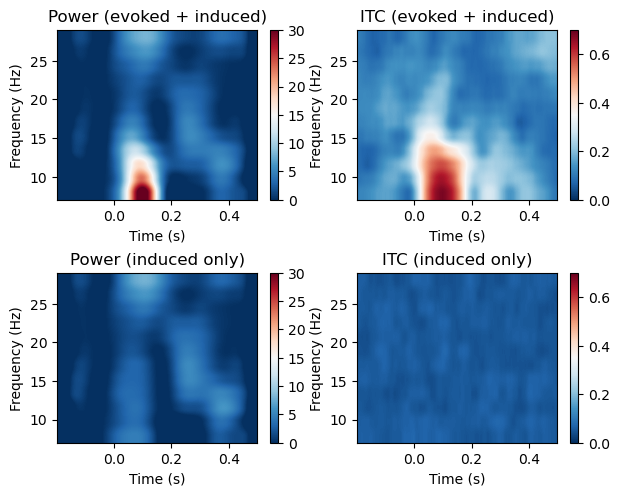

In [8]:
for ii, (this_epochs, title) in enumerate(
    zip([epochs, epochs_induced], ["evoked + induced", "induced only"])
):
    # compute the source space power and the inter-trial coherence
    power, itc = source_induced_power(
        this_epochs,
        inverse_operator,
        freqs,
        label,
        baseline=(-0.1, 0),
        baseline_mode="percent",
        n_cycles=n_cycles,
        n_jobs=None,
    )
    
    power = np.mean(power, axis=0)  # average over sources
    itc = np.mean(itc, axis=0)  # average over sources
    times = epochs.times
##########################################################################
    # View time-frequency plots
    plt.subplots_adjust(0.1, 0.08, 0.96, 0.94, 0.2, 0.43)
    plt.subplot(2, 2, 2 * ii + 1) # 画1，3图
    plt.imshow(
        20 * power,
        extent=[times[0], times[-1], freqs[0], freqs[-1]],
        aspect="auto",
        origin="lower",
        vmin=0.0,
        vmax=30.0,
        cmap="RdBu_r",
    )
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title("Power (%s)" % title)
    plt.colorbar()

    plt.subplot(2, 2, 2 * ii + 2)  # 画2，4图
    plt.imshow(
        itc,
        extent=[times[0], times[-1], freqs[0], freqs[-1]],
        aspect="auto",
        origin="lower",
        vmin=0,
        vmax=0.7,
        cmap="RdBu_r",
    )
    plt.xlabel("Time (s)")
    plt.ylabel("Frequency (Hz)")
    plt.title("ITC (%s)" % title)
    plt.colorbar()
plt.show()